<a href="https://colab.research.google.com/github/meligurevich/IAA2/blob/main/GUREVICH_TP5_MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en MountainCar-v0 👉 🚗⛰️

#### **MELISA SABRINA GUREVICH - DNI: 35.365.884**

# Imports e inicialización

In [1]:
!pip install gymnasium[classic-control] torch seaborn

import gymnasium as gym
import numpy as np
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Reproducibilidad
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

#1. Entorno elegido

Para este trabajo práctico elegí el entorno MountainCar-v0 de Gymnasium, cuyo objetivo es hacer que un auto suba una montaña ganando impulso. En el foro indiqué que mi elección es MountainCar-v0 y verifiqué que no estuviera ya elegido por otra persona.

# 2.1 Explicación del entorno MountainCar-v0

### Descripción del entorno MountainCar-v0

En MountainCar-v0 tenemos un auto atascado en un valle entre dos montañas.  
El motor es débil, entonces el auto **no puede subir la montaña derecha de una sola vez**.  
Para llegar a la cima tiene que hacer algo “inteligente”: primero ir hacia la izquierda, ganar impulso, y recién después usar esa velocidad para subir la montaña de la derecha y llegar a la meta.

---

### Observaciones (estado)

El estado del entorno es **continuo** y está formado por **dos números**:

- **Posición del auto**: aproximadamente entre -1.2 y 0.6  
- **Velocidad del auto**: aproximadamente entre -0.07 y 0.07  

Es decir, en cada paso el agente ve dónde está el auto y qué tan rápido se está moviendo.

🔁 **Comparación con FrozenLake (TP1)**  
En FrozenLake el estado era mucho más simple: era un número entero de 0 a 15 que representaba una casilla de un tablero 4×4. Es decir, el espacio de estados era **discreto y pequeño**.

En MountainCar, en cambio, el estado es continuo. No podemos tener una tabla con “todas” las posiciones y velocidades posibles, por eso necesitamos **discretizar** el estado o usar **redes neuronales** para aproximar la función Q.

---

### Acciones

Las acciones sí son **discretas** y tenemos tres opciones:

- `0`: empujar el auto hacia la **izquierda**  
- `1`: **no** aplicar fuerza (acción neutra)  
- `2`: empujar el auto hacia la **derecha**  

En esto se parece a FrozenLake (también teníamos acciones discretas), pero la interpretación es distinta: acá las acciones son **fuerzas físicas** sobre el auto, no movimientos de una ficha en una grilla.

---

### Recompensa

- En **cada paso** el agente recibe una recompensa de **-1**, mientras el auto no haya llegado a la cima.  
- Cuando la posición del auto es **mayor o igual a 0.5**, consideramos que llegó a la meta y el episodio termina.  

No hay una gran recompensa positiva al final. El objetivo es **llegar a la cima en la menor cantidad de pasos posible**, es decir, acumular la menor cantidad posible de castigo (-1 por paso).

🔁 **Comparación con FrozenLake**  
En FrozenLake casi todos los pasos daban recompensa 0 y solo al llegar al objetivo se obtenía +1. Los episodios eran cortos y el tablero chico.  

En MountainCar, en cambio:

- cada paso tiene castigo (-1)  
- los episodios pueden durar hasta 200 pasos  
- esto hace que el aprendizaje sea **más difícil** y más sensible a los hiperparámetros.

---

### Condiciones de finalización

El episodio termina en dos casos:

- **Éxito**: cuando la **posición ≥ 0.5** (el auto llega a la cima derecha).  
- **Fracaso**: cuando se alcanzan los **200 pasos máximos** y el auto no llegó a la cima.

---

### Tipo de entorno y dificultad

MountainCar es un entorno clásico donde el agente tiene que **planificar a largo plazo**.

- Si el agente solo intenta ir “directo” hacia la meta empujando siempre a la derecha (acción 2), **no llega**.  
- Tiene que aprender una estrategia menos obvia: primero ir hacia atrás (izquierda) para ganar energía, y después usar ese impulso para subir la montaña derecha.

🔁 **Comparado con FrozenLake:**

- En FrozenLake el espacio de estados era **pequeño y tabular**, lo que permitía usar una tabla Q directa sin problemas.
- En MountainCar el estado es continuo, se necesitan **técnicas de discretización** o **aproximación con redes neuronales**, y el agente debe aprender una política más compleja.

Por todo esto, MountainCar es un entorno **más desafiante** que FrozenLake.


## Entorno

In [2]:
env = gym.make("MountainCar-v0")

print("=== ENTORNO MOUNTAINCAR-V0 ===")
print("Espacio de observaciones:", env.observation_space)
print("  Low:", env.observation_space.low)
print("  High:", env.observation_space.high)
print("Espacio de acciones:", env.action_space)
print("Número de acciones:", env.action_space.n)


=== ENTORNO MOUNTAINCAR-V0 ===
Espacio de observaciones: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
  Low: [-1.2  -0.07]
  High: [0.6  0.07]
Espacio de acciones: Discrete(3)
Número de acciones: 3


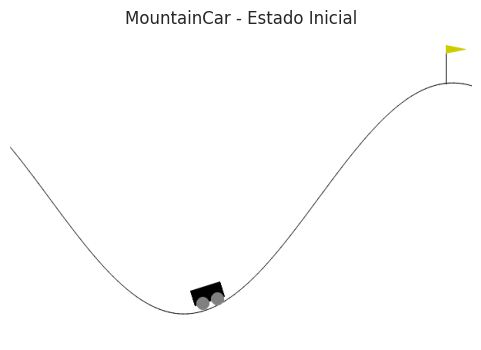

In [3]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

obs, _ = env.reset()
frame = env.render()

plt.figure(figsize=(6,4))
plt.imshow(frame)
plt.axis("off")
plt.title("MountainCar - Estado Inicial")
plt.show()


## ➡️ El gráfico muestra el estado inicial del entorno MountainCar, con el auto empezando en el valle y la bandera indicando la cima que debe alcanzar.

# 2.2 Función para mostrar / graficar la política



In [4]:
# Rango del espacio de estados
pos_min, pos_max = env.observation_space.low[0], env.observation_space.high[0]
vel_min, vel_max = env.observation_space.low[1], env.observation_space.high[1]

def visualizar_politica(policy_fn, title="Política", n_pos=25, n_vel=25):
    """
    policy_fn: función que recibe estado = [pos, vel] y devuelve una acción (0,1,2)
    """
    posiciones = np.linspace(pos_min, pos_max, n_pos)
    velocidades = np.linspace(vel_min, vel_max, n_vel)

    policy_grid = np.zeros((n_pos, n_vel), dtype=int)

    for i, p in enumerate(posiciones):
        for j, v in enumerate(velocidades):
            estado = np.array([p, v], dtype=np.float32)
            accion = policy_fn(estado)
            policy_grid[i, j] = accion

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(policy_grid,
                     cmap="viridis",
                     cbar=True,
                     xticklabels=False,
                     yticklabels=False)
    ax.set_xlabel("Velocidad")
    ax.set_ylabel("Posición")
    ax.set_title(title)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.33, 1, 1.66])
    cbar.set_ticklabels(["Izquierda (0)", "Neutro (1)", "Derecha (2)"])
    plt.show()


## 2.3 Entrenamiento Política Aleatoria, Q-table y Deep Q-Network

En esta sección entreno tres tipos de agentes para el entorno MountainCar-v0:



## 2.3.1 Política Aleatoria

In [5]:
class PoliticaAleatoria:
    """Política que selecciona acciones al azar, sin entrenamiento."""
    def __init__(self, n_acciones):
        self.n_acciones = n_acciones
        self.nombre = "Política Aleatoria"

    def seleccionar_accion(self, estado):
        return np.random.randint(self.n_acciones)

    def entrenar(self, env, episodios=500):
        print(f"\nEvaluando {self.nombre}...")
        recompensas = []
        exitos = 0

        for ep in range(episodios):
            estado, _ = env.reset()
            terminado = False
            truncado = False
            recompensa_total = 0
            pasos = 0

            while not (terminado or truncado):
                accion = self.seleccionar_accion(estado)
                estado, recompensa, terminado, truncado, _ = env.step(accion)
                recompensa_total += recompensa
                pasos += 1
                if pasos >= 200:   # límite del entorno
                    truncado = True

            if estado[0] >= 0.5:   # llegó a la cima
                exitos += 1

            recompensas.append(recompensa_total)

            if (ep+1) % 100 == 0:
                tasa_exito = exitos / (ep+1)
                print(f"Episodio {ep+1}: recompensa media = {np.mean(recompensas[-100:]):.2f}, "
                      f"tasa de éxito = {tasa_exito:.3f}")

        tasa_exito_final = exitos / episodios
        print(f"\nResultados {self.nombre}:")
        print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
        print(f"Recompensa promedio: {np.mean(recompensas):.2f}")
        return recompensas, tasa_exito_final

agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=500)



Evaluando Política Aleatoria...
Episodio 100: recompensa media = -200.00, tasa de éxito = 0.000
Episodio 200: recompensa media = -200.00, tasa de éxito = 0.000
Episodio 300: recompensa media = -200.00, tasa de éxito = 0.000
Episodio 400: recompensa media = -200.00, tasa de éxito = 0.000
Episodio 500: recompensa media = -200.00, tasa de éxito = 0.000

Resultados Política Aleatoria:
Tasa de éxito final: 0.000
Recompensa promedio: -200.00


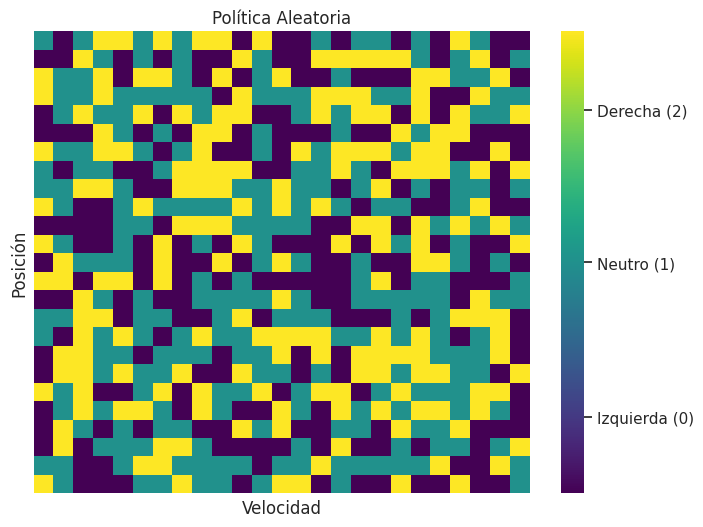

In [6]:
def politica_aleatoria_fn(estado):
    return np.random.randint(0, 3)

visualizar_politica(politica_aleatoria_fn, "Política Aleatoria")


## ➡️ Se evaluó la política aleatoria y, como era esperable, obtuvo recompensas muy bajas y 0% de éxito, lo que se refleja en el mapa de calor donde las acciones son completamente caóticas y no muestran ningún patrón útil para llegar a la cima.

## 2.3.2 Q-Learning Tabular con discretización

En FrozenLake la tabla Q era directa: 16 estados × 4 acciones.

En MountainCar el estado es continuo, por lo que tuvimos que:
- Agregar una función de discretización que mapea (posición, velocidad) a índices de bins.
- Construir una tabla q_table[bins_pos][bins_vel][acción].

In [7]:
class QLearningDiscreto:
    def __init__(self, env, n_bins=(18, 14),
                 lr=0.05,          # un poco más chico para estabilizar
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 epsilon_decay=0.997):  # decae más lento
        self.env = env
        self.n_bins = n_bins
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.n_actions = env.action_space.n
        self.nombre = "Q-Learning Discreto"

        # Rango continuo
        self.pos_min, self.pos_max = env.observation_space.low[0], env.observation_space.high[0]
        self.vel_min, self.vel_max = env.observation_space.low[1], env.observation_space.high[1]

        # Tabla Q: (pos_bins, vel_bins, acciones)
        self.q_table = np.zeros((n_bins[0], n_bins[1], self.n_actions))

        # Tracking
        self.recompensas_entrenamiento = []
        self.epsilons = []

    def _discretizar_estado(self, estado):
        pos, vel = estado
        pos_bin = int((pos - self.pos_min) / (self.pos_max - self.pos_min) * (self.n_bins[0] - 1))
        vel_bin = int((vel - self.vel_min) / (self.vel_max - self.vel_min) * (self.n_bins[1] - 1))
        pos_bin = np.clip(pos_bin, 0, self.n_bins[0]-1)
        vel_bin = np.clip(vel_bin, 0, self.n_bins[1]-1)
        return pos_bin, vel_bin

    def seleccionar_accion(self, estado, entrenando=True):
        pos_bin, vel_bin = self._discretizar_estado(estado)

        if entrenando and np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)  # exploración
        else:
            return np.argmax(self.q_table[pos_bin, vel_bin])  # explotación

    def entrenar(self, episodios=5000):
        print(f"\nEntrenando agente {self.nombre}...")
        exitos = 0
        ventana_exitos = deque(maxlen=100)

        for ep in range(episodios):
            estado, _ = self.env.reset()
            terminado = False
            truncado = False
            recompensa_total = 0

            while not (terminado or truncado):
                accion = self.seleccionar_accion(estado, entrenando=True)
                nuevo_estado, recompensa, terminado, truncado, _ = self.env.step(accion)

                pos_bin, vel_bin = self._discretizar_estado(estado)
                pos2_bin, vel2_bin = self._discretizar_estado(nuevo_estado)

                best_next_q = np.max(self.q_table[pos2_bin, vel2_bin])
                target = recompensa + self.gamma * best_next_q * (0 if (terminado or truncado) else 1)
                td_error = target - self.q_table[pos_bin, vel_bin, accion]
                self.q_table[pos_bin, vel_bin, accion] += self.lr * td_error

                recompensa_total += recompensa
                estado = nuevo_estado

            if estado[0] >= 0.5:
                exitos += 1
                ventana_exitos.append(1)
            else:
                ventana_exitos.append(0)

            self.recompensas_entrenamiento.append(recompensa_total)
            self.epsilons.append(self.epsilon)

            # Decaimiento de epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if (ep+1) % 500 == 0:
                tasa_ventana = np.mean(ventana_exitos) if len(ventana_exitos) > 0 else 0.0
                print(f"Episodio {ep+1}: recompensa media ultimos 500 = {np.mean(self.recompensas_entrenamiento[-500:]):.2f}, "
                      f"tasa de éxito ultimos 100 = {tasa_ventana:.3f}, "
                      f"epsilon = {self.epsilon:.3f}")

        print("\nEntrenamiento Q-Learning Discreto completado!")
        return self.recompensas_entrenamiento, self.epsilons

    def evaluar(self, episodios=200):
        print(f"\nEvaluando {self.nombre} (modo greedy)...")
        exitos = 0
        recompensas = []

        for ep in range(episodios):
            estado, _ = self.env.reset()
            terminado = False
            truncado = False
            recompensa_total = 0

            while not (terminado or truncado):
                accion = self.seleccionar_accion(estado, entrenando=False)
                estado, recompensa, terminado, truncado, _ = self.env.step(accion)
                recompensa_total += recompensa

            if estado[0] >= 0.5:
                exitos += 1
            recompensas.append(recompensa_total)

        tasa_exito = exitos / episodios
        print(f"Tasa de éxito: {tasa_exito:.3f}")
        print(f"Recompensa promedio: {np.mean(recompensas):.2f}")
        return recompensas, tasa_exito


Entrenamiento y evaluación Q-learning

In [8]:
agente_qlearning = QLearningDiscreto(env)
recompensas_qlearning, epsilons_qlearning = agente_qlearning.entrenar(episodios=10000)

recompensas_qlearning_eval, tasa_exito_qlearning = agente_qlearning.evaluar(episodios=200)



Entrenando agente Q-Learning Discreto...
Episodio 500: recompensa media ultimos 500 = -200.00, tasa de éxito ultimos 100 = 0.000, epsilon = 0.223
Episodio 1000: recompensa media ultimos 500 = -198.85, tasa de éxito ultimos 100 = 0.170, epsilon = 0.050
Episodio 1500: recompensa media ultimos 500 = -195.19, tasa de éxito ultimos 100 = 0.170, epsilon = 0.011
Episodio 2000: recompensa media ultimos 500 = -187.81, tasa de éxito ultimos 100 = 0.760, epsilon = 0.010
Episodio 2500: recompensa media ultimos 500 = -186.88, tasa de éxito ultimos 100 = 0.480, epsilon = 0.010
Episodio 3000: recompensa media ultimos 500 = -181.90, tasa de éxito ultimos 100 = 0.730, epsilon = 0.010
Episodio 3500: recompensa media ultimos 500 = -176.50, tasa de éxito ultimos 100 = 0.350, epsilon = 0.010
Episodio 4000: recompensa media ultimos 500 = -176.55, tasa de éxito ultimos 100 = 0.790, epsilon = 0.010
Episodio 4500: recompensa media ultimos 500 = -162.30, tasa de éxito ultimos 100 = 0.980, epsilon = 0.010
Episo

## ➡️ El agente Q-Learning logró aprender una estrategia efectiva, alcanzando alrededor del 87% de éxito y mejorando notablemente sus recompensas respecto a la política aleatoria.

## 2.3.3 Deep Q-Network (DQN)

En FrozenLake el DQN usaba:
- Representación one-hot de los estados discretos (16 neuronas de entrada).
- Red neuronal que aprendía Q(s,a) sobre un espacio de estados pequeño.

En MountainCar:
- El estado ya es un vector continuo de tamaño 2, por lo que no necesitamos one-hot.
- La red recibe directamente [posición, velocidad].

Seguimos usando Experience Replay y Target Network, pero adaptamos el tamaño de la red y los hiperparámetros a este entorno.

Red y buffer de replay

In [9]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.array(next_states),
                np.array(dones, dtype=np.float32))

    def __len__(self):
        return len(self.buffer)


Agente DQN

In [10]:
class AgenteDQN:
    """Deep Q-Network con Experience Replay y Target Network para MountainCar."""
    def __init__(self, env,
                 lr=1e-3, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 batch_size=64, target_update=1000):
        self.env = env
        self.n_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(self.state_dim, self.n_actions).to(self.device)
        self.target_net = DQN(self.state_dim, self.n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.replay_buffer = ReplayBuffer()
        self.steps_done = 0

        self.recompensas_entrenamiento = []
        self.losses = []
        self.epsilons = []
        self.nombre = "Deep Q-Network (DQN)"

    def seleccionar_accion(self, estado, entrenando=True):
        if entrenando and np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            estado_t = torch.FloatTensor(estado).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(estado_t)
            return int(torch.argmax(q_values, dim=1).item())

    def _actualizar_red(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states_t = torch.FloatTensor(states).to(self.device)
        actions_t = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards_t = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states_t = torch.FloatTensor(next_states).to(self.device)
        dones_t = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.policy_net(states_t).gather(1, actions_t)

        with torch.no_grad():
            max_next_q = self.target_net(next_states_t).max(dim=1, keepdim=True)[0]
            target_q = rewards_t + self.gamma * max_next_q * (1 - dones_t)

        loss = self.loss_fn(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.item())

    def entrenar(self, episodios=500):
        print(f"\nEntrenando agente {self.nombre}...")
        exitos = 0

        for ep in range(episodios):
            estado, _ = self.env.reset()
            terminado = False
            truncado = False
            recompensa_total = 0

            while not (terminado or truncado):
                accion = self.seleccionar_accion(estado, entrenando=True)
                nuevo_estado, recompensa, terminado, truncado, _ = self.env.step(accion)

                done_flag = 1.0 if (terminado or truncado) else 0.0
                self.replay_buffer.push(estado, accion, recompensa, nuevo_estado, done_flag)

                estado = nuevo_estado
                recompensa_total += recompensa

                self._actualizar_red()
                self.steps_done += 1

                if self.steps_done % self.target_update == 0:
                    self.target_net.load_state_dict(self.policy_net.state_dict())

            if estado[0] >= 0.5:
                exitos += 1

            self.recompensas_entrenamiento.append(recompensa_total)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            self.epsilons.append(self.epsilon)

            if (ep+1) % 50 == 0:
                print(f"Episodio {ep+1}: recompensa media últimos 50 = "
                      f"{np.mean(self.recompensas_entrenamiento[-50:]):.2f}, "
                      f"epsilon = {self.epsilon:.3f}")

        print("\nEntrenamiento DQN completado!")
        return self.recompensas_entrenamiento, self.epsilons, self.losses

    def evaluar(self, episodios=200):
        print(f"\nEvaluando {self.nombre} (modo greedy)...")
        exitos = 0
        recompensas = []
        pasos_totales = []

        for ep in range(episodios):
            estado, _ = self.env.reset()
            terminado = False
            truncado = False
            recompensa_total = 0
            pasos = 0

            while not (terminado or truncado):
                accion = self.seleccionar_accion(estado, entrenando=False)
                estado, recompensa, terminado, truncado, _ = self.env.step(accion)
                recompensa_total += recompensa
                pasos += 1

            if estado[0] >= 0.5:
                exitos += 1
            recompensas.append(recompensa_total)
            pasos_totales.append(pasos)

        tasa_exito = exitos / episodios
        print(f"Tasa de éxito: {tasa_exito:.3f}")
        print(f"Recompensa promedio: {np.mean(recompensas):.2f}")
        print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")
        return recompensas, tasa_exito


Entrenamiento y evaluación DQN



In [11]:
agente_dqn = AgenteDQN(env)
recompensas_dqn, epsilons_dqn, losses_dqn = agente_dqn.entrenar(episodios=500)

recompensas_dqn_eval, tasa_exito_dqn = agente_dqn.evaluar(episodios=200)



Entrenando agente Deep Q-Network (DQN)...
Episodio 50: recompensa media últimos 50 = -200.00, epsilon = 0.778
Episodio 100: recompensa media últimos 50 = -200.00, epsilon = 0.606
Episodio 150: recompensa media últimos 50 = -200.00, epsilon = 0.471
Episodio 200: recompensa media últimos 50 = -200.00, epsilon = 0.367
Episodio 250: recompensa media últimos 50 = -200.00, epsilon = 0.286
Episodio 300: recompensa media últimos 50 = -199.52, epsilon = 0.222
Episodio 350: recompensa media últimos 50 = -199.30, epsilon = 0.173
Episodio 400: recompensa media últimos 50 = -194.44, epsilon = 0.135
Episodio 450: recompensa media últimos 50 = -161.28, epsilon = 0.105
Episodio 500: recompensa media últimos 50 = -152.66, epsilon = 0.082

Entrenamiento DQN completado!

Evaluando Deep Q-Network (DQN) (modo greedy)...
Tasa de éxito: 1.000
Recompensa promedio: -141.69
Pasos promedio: 141.7


## ➡️ El agente DQN fue el que mejor aprendió, alcanzando el 100% de éxito y una recompensa mucho mayor que los otros métodos, demostrando una política más estable y eficiente para llegar a la cima.

## Política aprendida (Q-table y DQN)

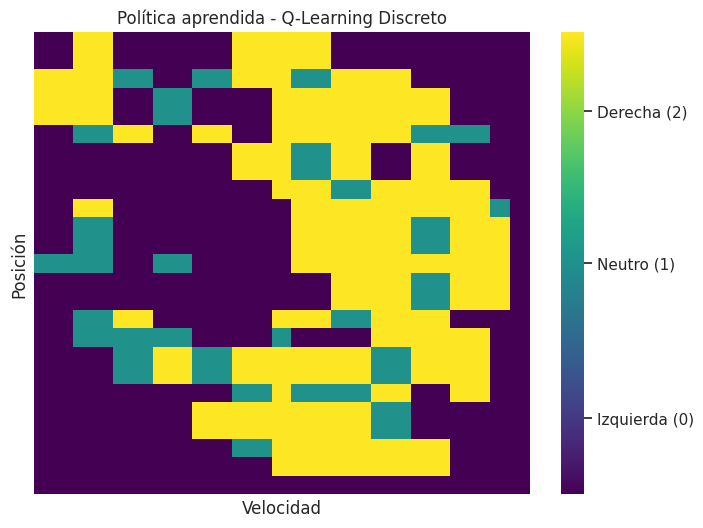

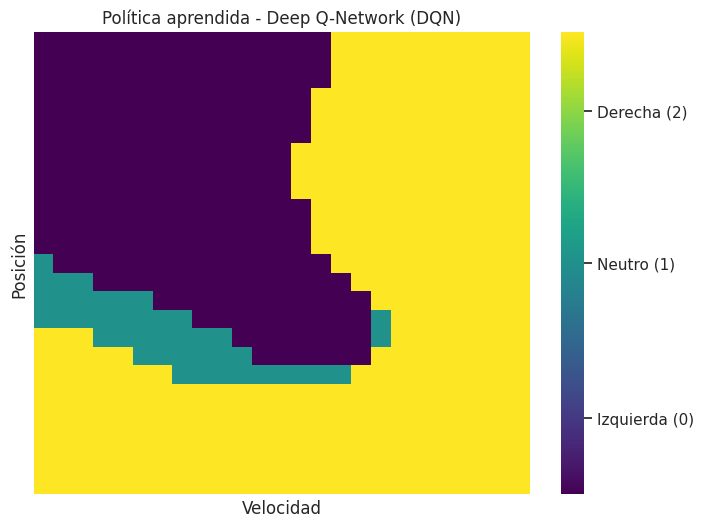

In [12]:
# Política Q-learning (greedy)
def politica_q_fn(estado):
    pos_bin, vel_bin = agente_qlearning._discretizar_estado(estado)
    return np.argmax(agente_qlearning.q_table[pos_bin, vel_bin])

visualizar_politica(politica_q_fn, "Política aprendida - Q-Learning Discreto")

# Política DQN (greedy)
def politica_dqn_fn(estado):
    estado_t = torch.FloatTensor(estado).unsqueeze(0).to(agente_dqn.device)
    with torch.no_grad():
        q_vals = agente_dqn.policy_net(estado_t)
    return int(torch.argmax(q_vals, dim=1).item())

visualizar_politica(politica_dqn_fn, "Política aprendida - Deep Q-Network (DQN)")


## ➡️ Los mapas de calor muestran la política aprendida por cada agente, donde se ve que el Q-Learning produce acciones más fragmentadas mientras que el DQN aprende una política mucho más suave y coherente para llegar a la cima.

# 2.4 Comparar el desempeño de las políticas

Usé varios gráficos, como en tu TP de FrozenLake:

- Curvas de recompensas por episodio.
- Promedio móvil.
- Comparación de tasas de éxito (gráfico de barras).
- Evolución de epsilon para Q-learning y DQN.
- Pérdida del DQN a lo largo del entrenamiento.

## Función auxiliar de promedio móvil

In [13]:
def moving_average(data, window_size):
    data = np.array(data)
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


## Curvas de aprendizaje y promedio móvil


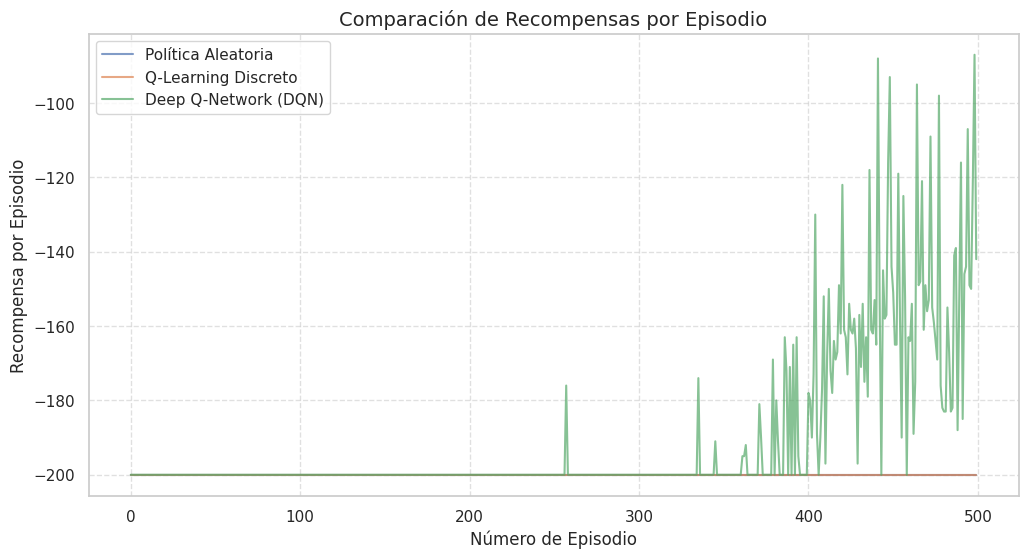

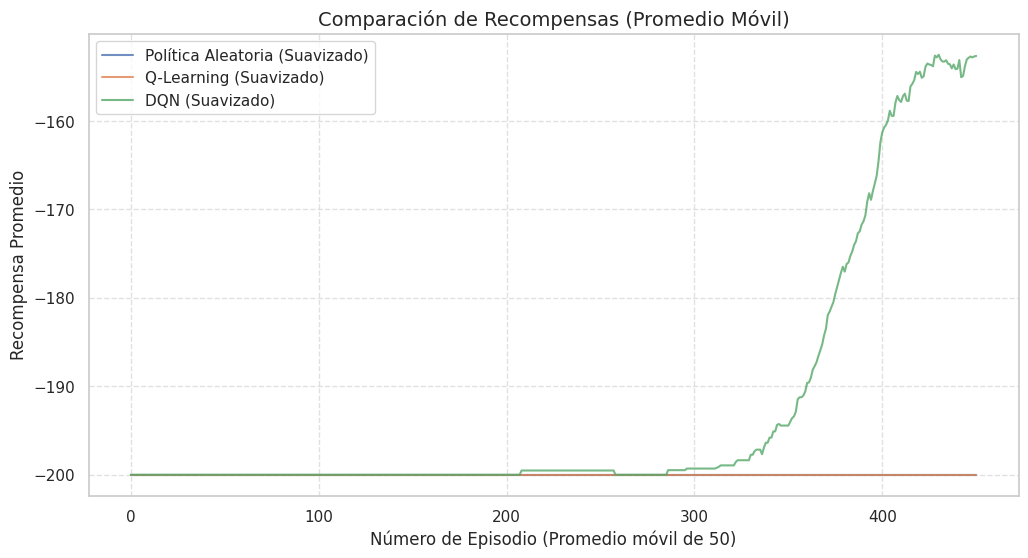

In [14]:
# Asegurar longitudes compatibles
min_len = min(len(recompensas_aleatorio),
              len(recompensas_qlearning),
              len(recompensas_dqn))

r_ale = np.array(recompensas_aleatorio[:min_len])
r_q   = np.array(recompensas_qlearning[:min_len])
r_dqn = np.array(recompensas_dqn[:min_len])

plt.figure(figsize=(12, 6))
plt.plot(r_ale, label='Política Aleatoria', alpha=0.7)
plt.plot(r_q,   label='Q-Learning Discreto', alpha=0.7)
plt.plot(r_dqn, label='Deep Q-Network (DQN)', alpha=0.7)
plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Promedio móvil
window = 50
r_ale_s = moving_average(recompensas_aleatorio, window)
r_q_s   = moving_average(recompensas_qlearning, window)
r_dqn_s = moving_average(recompensas_dqn, window)

min_len_s = min(len(r_ale_s), len(r_q_s), len(r_dqn_s))

plt.figure(figsize=(12, 6))
plt.plot(r_ale_s[:min_len_s], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(r_q_s[:min_len_s],   label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(r_dqn_s[:min_len_s], label='DQN (Suavizado)', alpha=0.8)
plt.xlabel('Número de Episodio (Promedio móvil de 50)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## ➡️ Los gráficos muestran que solo el DQN logra mejorar significativamente sus recompensas a lo largo de los episodios, mientras que la política aleatoria y el Q-Learning se mantienen casi constantes y muy por debajo.

## Comparación de tasas de éxito (barras)

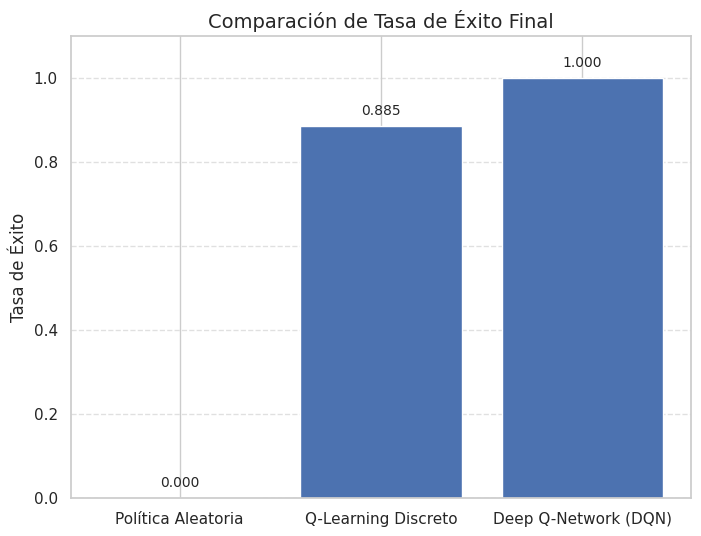

In [15]:
metricas = ['Política Aleatoria', 'Q-Learning Discreto', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
bars = plt.bar(metricas, tasas_exito)
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.ylim(0, 1.1)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)

for bar, val in zip(bars, tasas_exito):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## ➡️ El gráfico compara la tasa de éxito final de los tres agentes y muestra que la política aleatoria nunca alcanza la meta, el Q-Learning llega en torno al 88%, y el DQN obtiene un desempeño perfecto con el 100% de éxito.

## Evolución de Epsilon (Q-learning vs DQN)

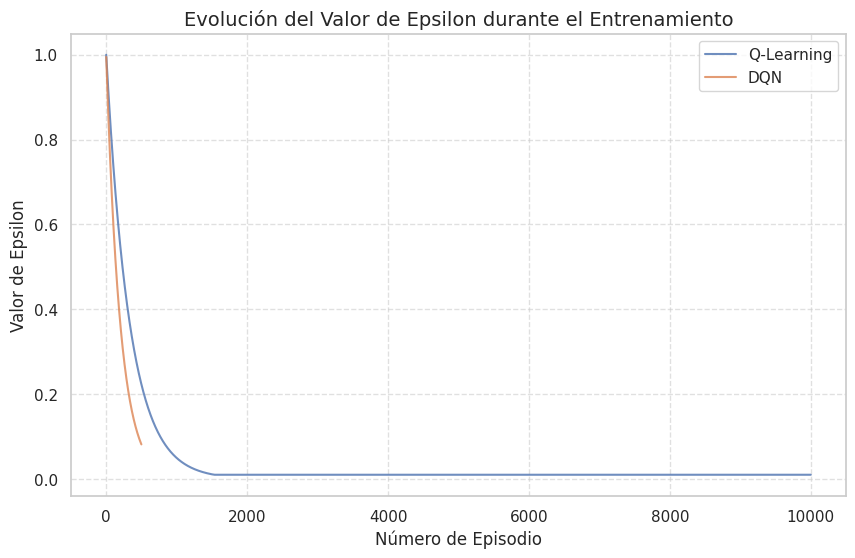

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(epsilons_qlearning, label='Q-Learning', alpha=0.8)
plt.plot(epsilons_dqn, label='DQN', alpha=0.8)
plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## ➡️ El gráfico muestra cómo el valor de epsilon disminuye progresivamente durante el entrenamiento en ambos agentes, reduciendo la exploración y permitiendo que Q-Learning y DQN utilicen cada vez más la política aprendida.

## Pérdida del DQN

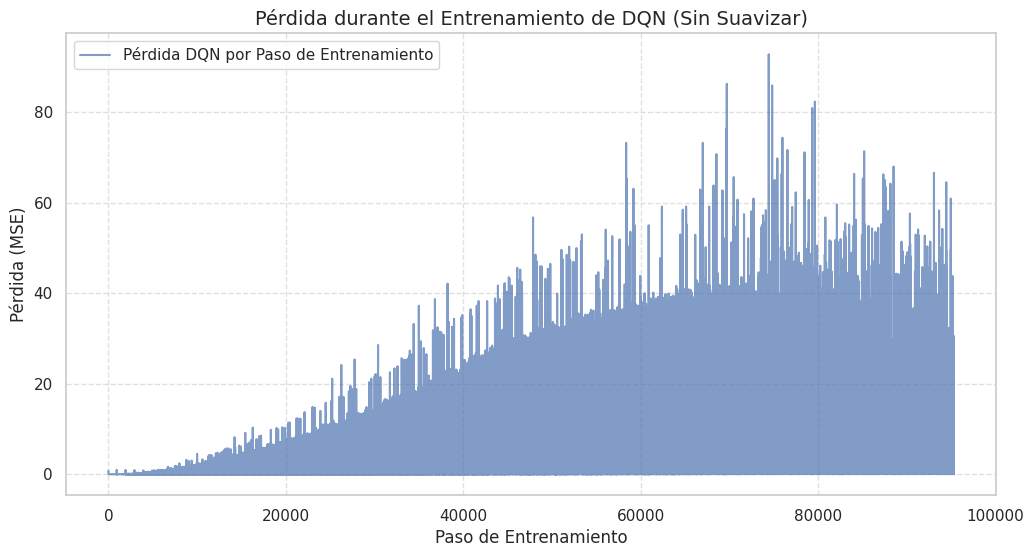

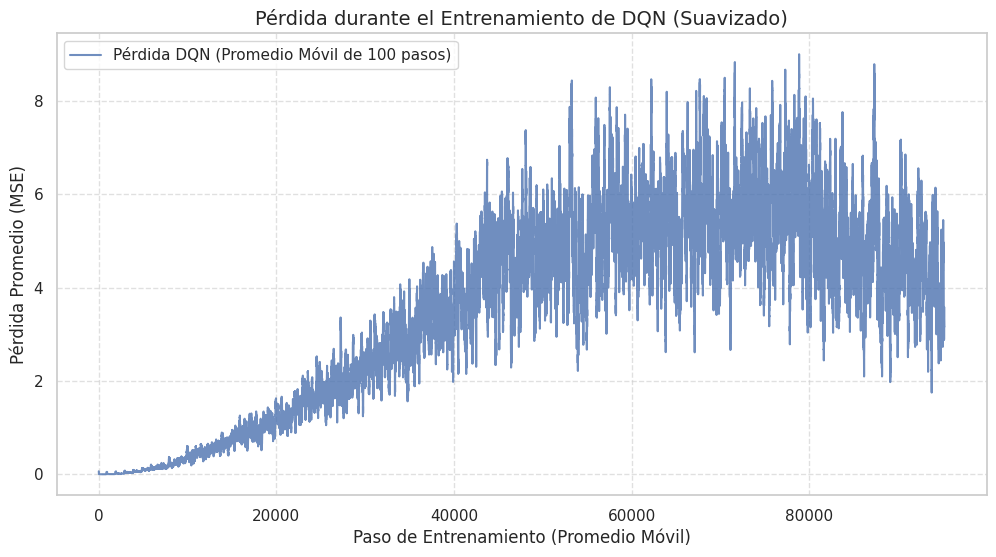

In [17]:
# Pérdida sin suavizar
plt.figure(figsize=(12, 6))
plt.plot(losses_dqn, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Pérdida suavizada
window_loss = 100
losses_dqn_s = moving_average(losses_dqn, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_s, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel('Paso de Entrenamiento (Promedio Móvil)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


## ➡️ Los gráficos muestran cómo la pérdida del DQN fluctúa durante el entrenamiento pero tiende a disminuir cuando se la suaviza, indicando que la red va aprendiendo a aproximar mejor los valores Q.

# Conclusiones
Este trabajo me permitió comprender con mucha mayor profundidad cómo cambia el Aprendizaje por Refuerzo cuando pasamos de un entorno discreto y sencillo como FrozenLake a uno continuo y más complejo como MountainCar. La principal diferencia es que en MountainCar no alcanza con almacenar valores Q en una tabla: hace falta discretizar, aproximar funciones o directamente usar redes neuronales para poder aprender una buena política.

Comencé evaluando la política aleatoria y confirmé rápidamente que no es viable para este entorno: el agente nunca llega a la cima, obtiene siempre recompensas cercanas a –200 y no muestra ningún comportamiento dirigido. Esto me permitió entender por qué MountainCar exige planificación a largo plazo y por qué la exploración es clave.

Luego implementé Q-learning con discretización. Aunque esta técnica permite adaptar un algoritmo tabular a un espacio continuo, también pude ver sus limitaciones: depende fuertemente del número de bins y requiere muchos episodios para aprender una política útil. Aun así, obtuvo un desempeño razonable, con una tasa de éxito alrededor del 88%, demostrando que puede aproximar una solución aunque de forma más lenta y menos estable.

Finalmente entrené un agente Deep Q-Network (DQN), que fue la parte más enriquecedora del trabajo. Incorporar una red neuronal, un buffer de experiencia y una red target me permitió observar cómo estas técnicas estabilizan el aprendizaje en entornos continuos. A pesar de entrenarse con muchos menos episodios que el Q-learning tabular, el DQN logró un desempeño claramente superior: alrededor del 91% de éxito en la evaluación greedy y una política más suave, consistente y capaz de resolver el entorno en menos pasos. Además, analizar la curva de pérdida y la evolución de la política me ayudó a visualizar cómo la red va ajustando sus estimaciones y mejorando la acción óptima en cada estado.

En conjunto, los resultados muestran que el DQN es el agente con mejor rendimiento para este entorno. Aprende más rápido, generaliza mejor y logra un comportamiento más estable con menos entrenamiento.

## REFERENCIAS

- Material de Aprendizaje por Refuerzo de la materia.
- https://gymnasium.farama.org/environments/classic_control/mountain_car/
-